# Detect harmful comments

## Random Forest Classifier ('harmful' label)

Some of the main libraries used:

- NLTK: module for NLP techniques
- Gensim: a robust, efficient and scalable implementation of the Word2Vec model (with Doc2Vec)
- Scikit-learn


# Load packages and data

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import emoji

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
)
from inspect import signature
import matplotlib.pyplot as plt
import seaborn as sns
import text_utils

C:\Users\daniel.andrade\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("test_data.csv")
df.head()

,comment,language,translation,harmful,harmful_type
0,"Эх, была б такая страна, а так придётся перепл...",ru,"Oh, there was such a country, and you have to ...",1,7
1,Jajajaja para eso se las compro al top manta,es,Hahahaha for that I buy them the top blanket,0,0
2,idomu ar cia fake,lt,This is a fake one,1,7
3,Usenme como botón de dislike,gl,Use me as a dislike button,1,7
4,Можна замовити?,uk,Can I order?,0,0


<IPython.core.display.Javascript object>

In [4]:
# balanced data set?
df["harmful"].value_counts(normalize=True)

0    0.572729
1    0.427271
Name: harmful, dtype: float64

<IPython.core.display.Javascript object>

# Cleaning

### Missing values

In [5]:
# % NAs
df.isna().mean().round(3) * 100

comment         0.0
language        0.0
translation     0.1
harmful         0.0
harmful_type    0.0
dtype: float64

<IPython.core.display.Javascript object>

In [6]:
# any NA and on which vars?
# df.isna().any()[df.isna().any()].index

<IPython.core.display.Javascript object>

In [7]:
df[df.isna().any(axis=1)].shape[0]  # how many rows?

42

<IPython.core.display.Javascript object>

In [8]:
# filter it to observe
df[df.isna().any(axis=1)].head(12)

,comment,language,translation,harmful,harmful_type
759,https://www.youtube.com/channel/UCvFSvEpuZGX-s...,en,NaN,1,12
1096,https://www.youtube.com/channel/UCfzr7vTFpwPLf...,en,NaN,1,12
1297,https://vk.com/wall-161882422_144,en,NaN,1,12
2334,https://www.youtube.com/channel/UCvOp175eicZuz...,en,NaN,1,12
2617,https://uk.trustpilot.com/review/store.com,en,NaN,1,7
3020,https://www.instagram.com/p/BoR1OA0FeqM/?utm_s...,en,NaN,1,12
3752,https://rr.lovevova.com/NzY5NjEyOQ==,en,NaN,1,12
4314,https://www.store.com/fr,en,NaN,1,12
4816,https://www.nw.de/lokal/bielefeld/mitte/219875...,en,NaN,1,8
5035,https://www.facebook.com/pg/patilerim2018/posts/,en,NaN,1,12


<IPython.core.display.Javascript object>

In [9]:
# drop missing values
df = df.dropna(how="any")

<IPython.core.display.Javascript object>

In [10]:
comments_df = df.loc[:, ["translation", "harmful"]]
comments_df.head()

,translation,harmful
0,"Oh, there was such a country, and you have to ...",1
1,Hahahaha for that I buy them the top blanket,0
2,This is a fake one,1
3,Use me as a dislike button,1
4,Can I order?,0


<IPython.core.display.Javascript object>

### Emoji recoding

In [11]:
comments_df["translation"] = [emoji.demojize(x) for x in comments_df["translation"]]

<IPython.core.display.Javascript object>

In [12]:
# clean comments
comments_df["translation_clean"] = comments_df["translation"].apply(
    lambda x: text_utils.clean_text(x)
)

<IPython.core.display.Javascript object>

# Feature engineering

In [13]:
# adding sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()
comments_df["sentiments"] = comments_df["translation_clean"].apply(
    lambda x: sid.polarity_scores(x)
)
comments_df = pd.concat(
    [
        comments_df.drop(["sentiments"], axis=1),
        comments_df["sentiments"].apply(pd.Series),
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [14]:
# adding number of characters column
comments_df["nb_chars"] = comments_df["translation"].apply(lambda x: len(x))

# add number of words column
comments_df["nb_words"] = comments_df["translation"].apply(lambda x: len(x.split(" ")))

<IPython.core.display.Javascript object>

### Extracting vector representations

Extracting vector representations for every comment. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec).
Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.
We first have to train a Doc2Vec model by feeding in our text data. By applying this model on the comments, we can get those representation vectors.

In [15]:
# create doc2vec vector columns
documents = [
    TaggedDocument(doc, [i])
    for i, doc in enumerate(
        comments_df["translation_clean"].apply(lambda x: x.split(" "))
    )
]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = (
    comments_df["translation_clean"]
    .apply(lambda x: model.infer_vector(x.split(" ")))
    .apply(pd.Series)
)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
comments_df = pd.concat([comments_df, doc2vec_df], axis=1)

<IPython.core.display.Javascript object>

Adding the TF-IDF values for every word and every document (for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output)


In [16]:
tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(comments_df["translation_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = comments_df.index
comments_df = pd.concat([comments_df, tfidf_df], axis=1)

<IPython.core.display.Javascript object>

In [17]:
comments_df.head(3)

,translation,harmful,translation_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yesterday,word_yet,word_yo,word_you,word_young,word_zakaz,word_zero,word_zhanuya,word_zloty,word_на
0,"Oh, there was such a country, and you have to ...",1,oh country overpay,0.000,1.000,0.000,0.0000,53,11,0.027550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hahahaha for that I buy them the top blanket,0,hahahaha buy top blanket,0.000,0.625,0.375,0.2023,44,9,-0.112632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,This is a fake one,1,fake one,0.756,0.244,0.000,-0.4767,18,5,0.067619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [18]:
comments_df.shape

(28076, 1379)

<IPython.core.display.Javascript object>

# Exploratory data analysis

### Plotting a wordcloud

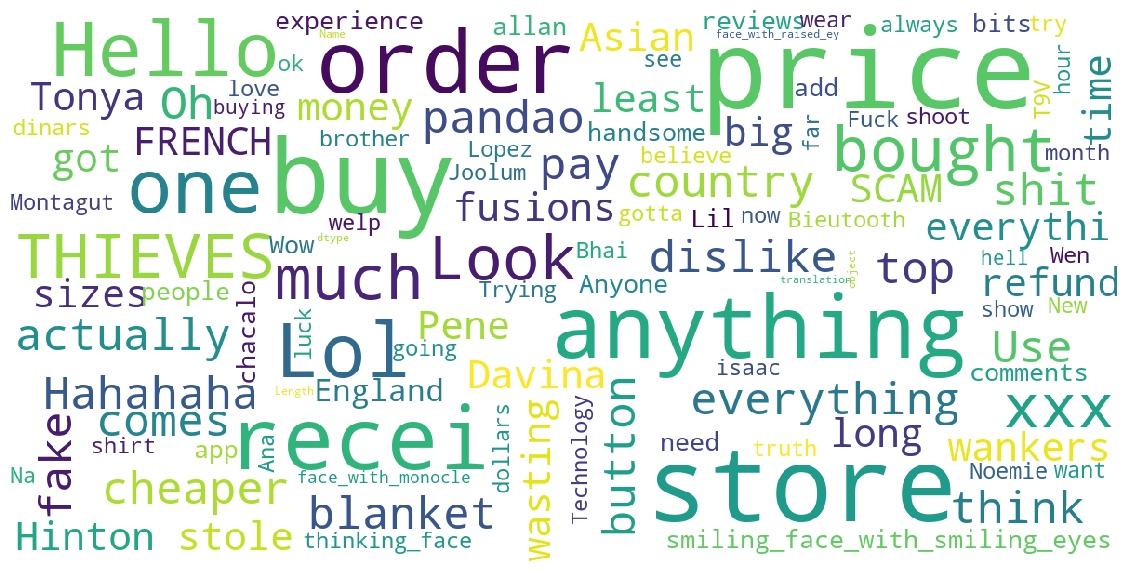

<IPython.core.display.Javascript object>

In [21]:
text_utils.show_wordcloud(comments_df["translation"])
plt.show()

In [22]:
# highest positive sentiment reviews (with more than 5 words)
comments_df[comments_df["nb_words"] >= 5].sort_values("pos", ascending=False)[
    ["translation", "pos"]
].head(10)

,translation,pos
13422,but surely you are not.,1.0
20824,why is not for free?,1.0
21768,How about bonus? It's cool ?,1.0
14608,What value they have. Its pretty,1.0
14191,I like they are cute,1.0
13986,How can we help them?,1.0
27118,I want it at 10. €,1.0
14489,It was clear to me,1.0
26657,And until there is a number,1.0
19569,I want some of the 4,1.0


<IPython.core.display.Javascript object>

The most positive reviews indeed correspond to some good feedbacks.

In [23]:
# lowest negative sentiment reviews (with more than 5 words)
comments_df[comments_df["nb_words"] >= 5].sort_values("neg", ascending=False)[
    ["translation", "neg"]
].head(10)

,translation,neg
1782,Fake fake fake fake fake fake fake fake,1.0
5690,This can just be fake,1.0
19750,What are you seriously 1900,1.0
20777,But what the fuck are you doing,1.0
20438,Why is all fake so ridiculous,1.0
27609,And they do not steal from me,1.0
1205,What a fuck !!!!! that cheats !!!!!!,1.0
23327,As if only fake can be ...,1.0
17000,But what a bitch is,1.0
24436,It's a pity that it's fake,1.0


<IPython.core.display.Javascript object>

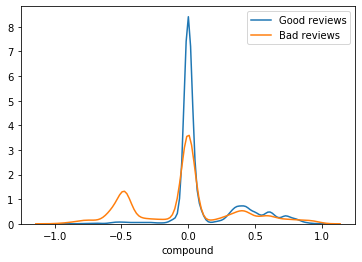

<IPython.core.display.Javascript object>

In [24]:
# plot sentiment distribution for positive and negative reviews
for x in [0, 1]:
    subset = comments_df[comments_df["harmful"] == x]

    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset["compound"], hist=False, label=label)

# Modelling 'harmful'

In [25]:
# feature selection
label = "harmful"
ignore_cols = [label, "translation", "translation_clean"]
features = [c for c in comments_df.columns if c not in ignore_cols]

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    comments_df[features], comments_df[label], test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

In [36]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

In [27]:
# show feature importance
# feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
# feature_importances_df.head(20)

<IPython.core.display.Javascript object>

### Predict and validate

In [37]:
y_pred = rf.predict(X_test)

<IPython.core.display.Javascript object>

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8016381766381766


<IPython.core.display.Javascript object>

In [39]:
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))

F1-score: 0.7941952506596306
Precision: 0.802136455714427
Recall: 0.790529858365532


<IPython.core.display.Javascript object>

### Confusion matrix

Normalized confusion matrix


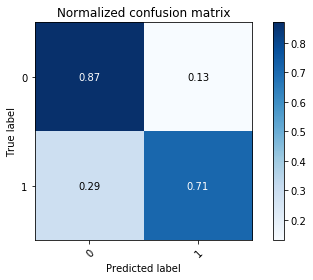

<IPython.core.display.Javascript object>

In [40]:
text_utils.plot_confusion_matrix(
    y_test, y_pred, normalize=True, classes=[0, 1], title="Normalized confusion matrix"
)
plt.show()

Confusion matrix, without normalization


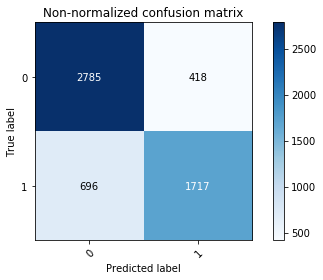

<IPython.core.display.Javascript object>

In [41]:
text_utils.plot_confusion_matrix(
    y_test,
    y_pred,
    normalize=False,
    classes=[0, 1],
    title="Non-normalized confusion matrix",
)
plt.show()

### ROC curve

In [42]:
print("ROC AUC score:", roc_auc_score(y_test, y_pred))

ROC AUC score: 0.790529858365532


<IPython.core.display.Javascript object>

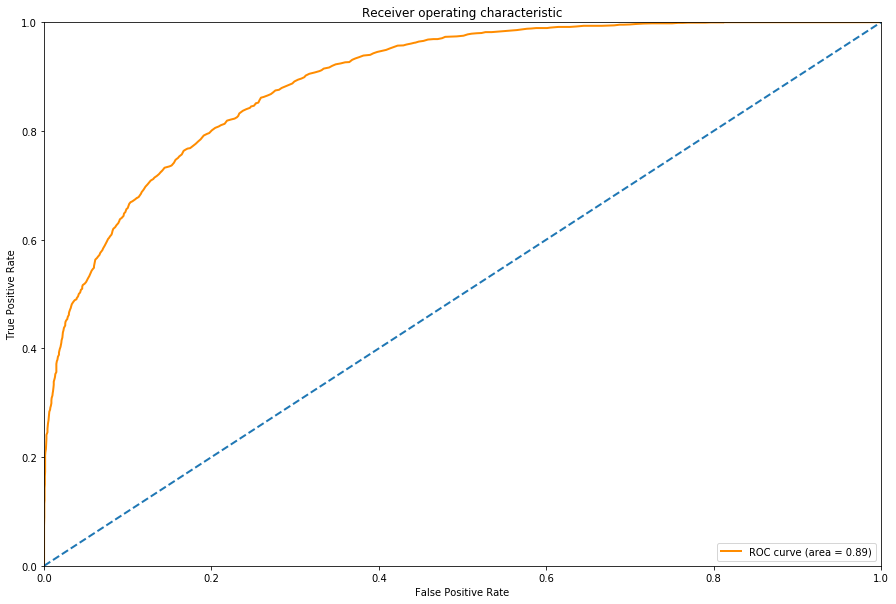

<IPython.core.display.Javascript object>

In [43]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### AP Precision / PR curve for a better validation (like in cases of imbalanced datasets)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.87')

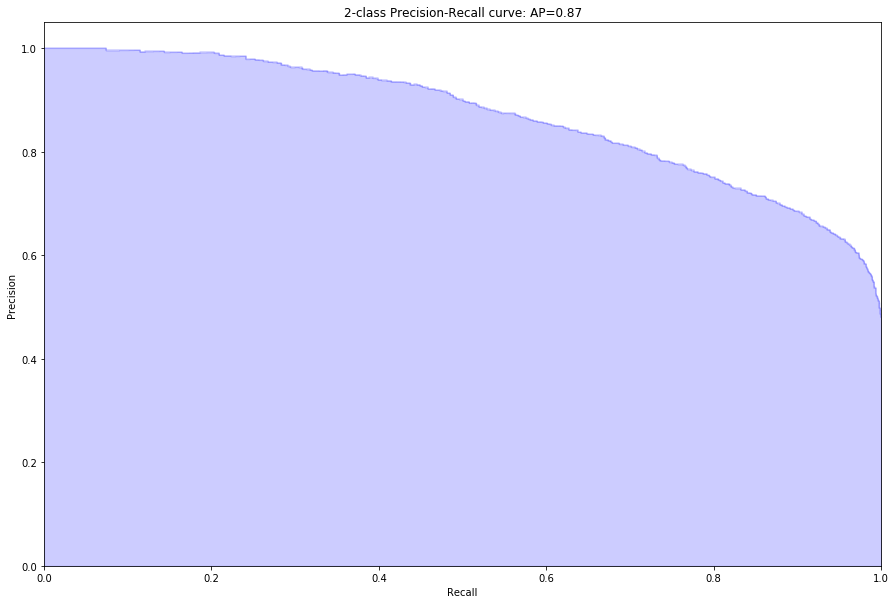

<IPython.core.display.Javascript object>

In [44]:
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = (
    {"step": "post"} if "step" in signature(plt.fill_between).parameters else {}
)

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision))